In [23]:
!pip install scikit-learn
!pip install matplotlib seaborn pandas scikit-learn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing()
x = housing.data
y = housing.target
feature_names = housing.feature_names


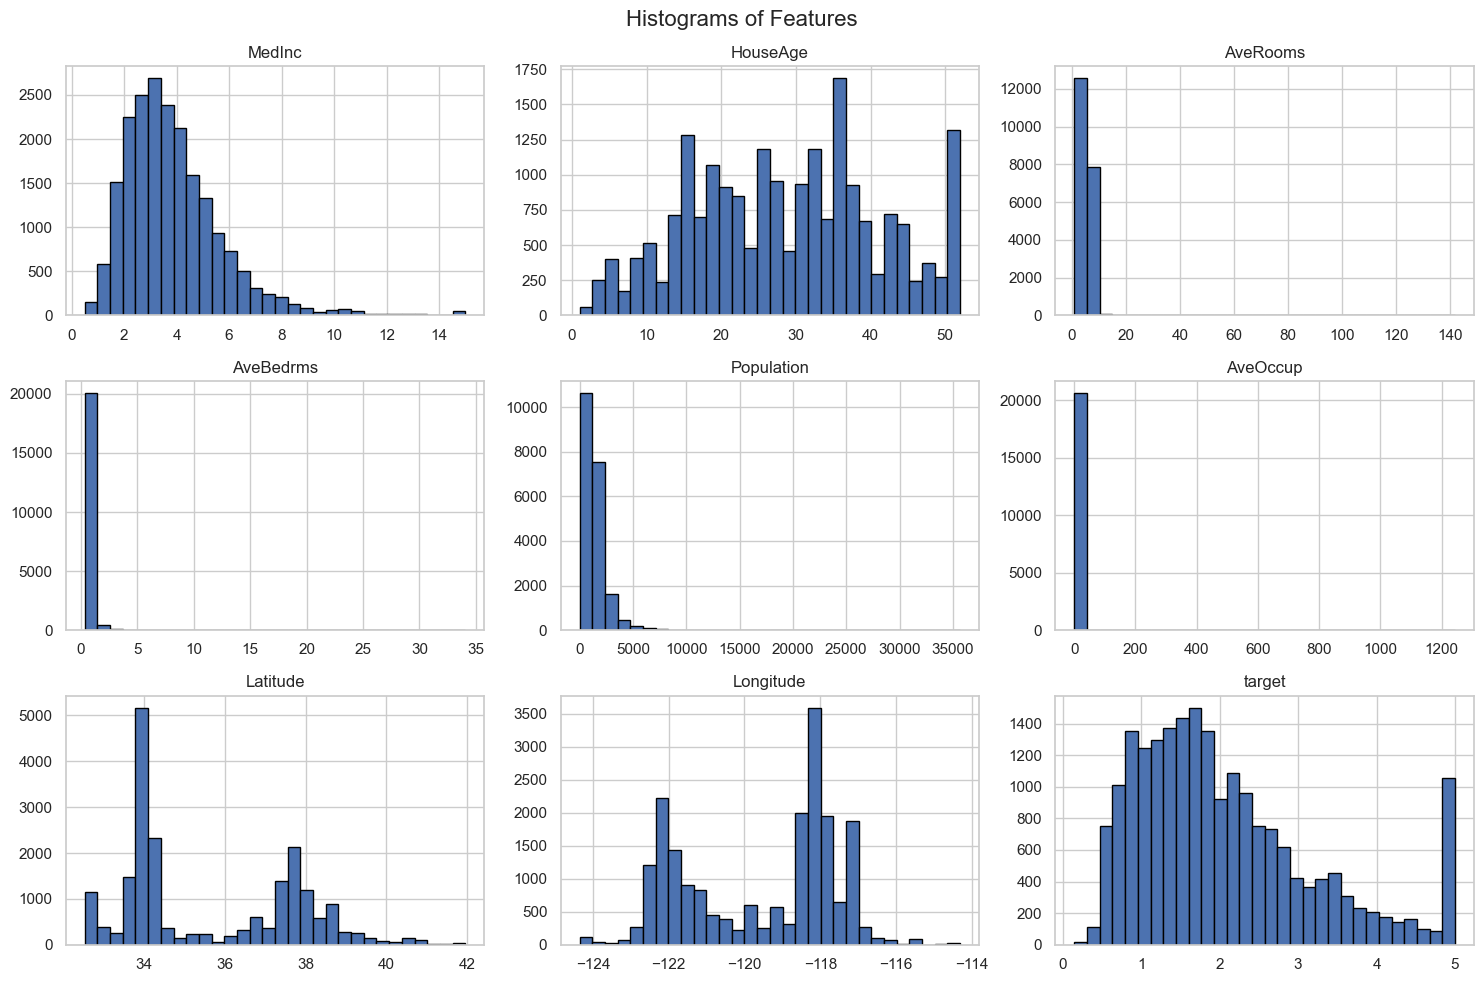

In [24]:
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target
sns.set(style="whitegrid")
df.hist(bins=30, figsize=(15,10), edgecolor='black')
plt.suptitle("Histograms of Features", fontsize = 16)
plt.tight_layout()
plt.show()


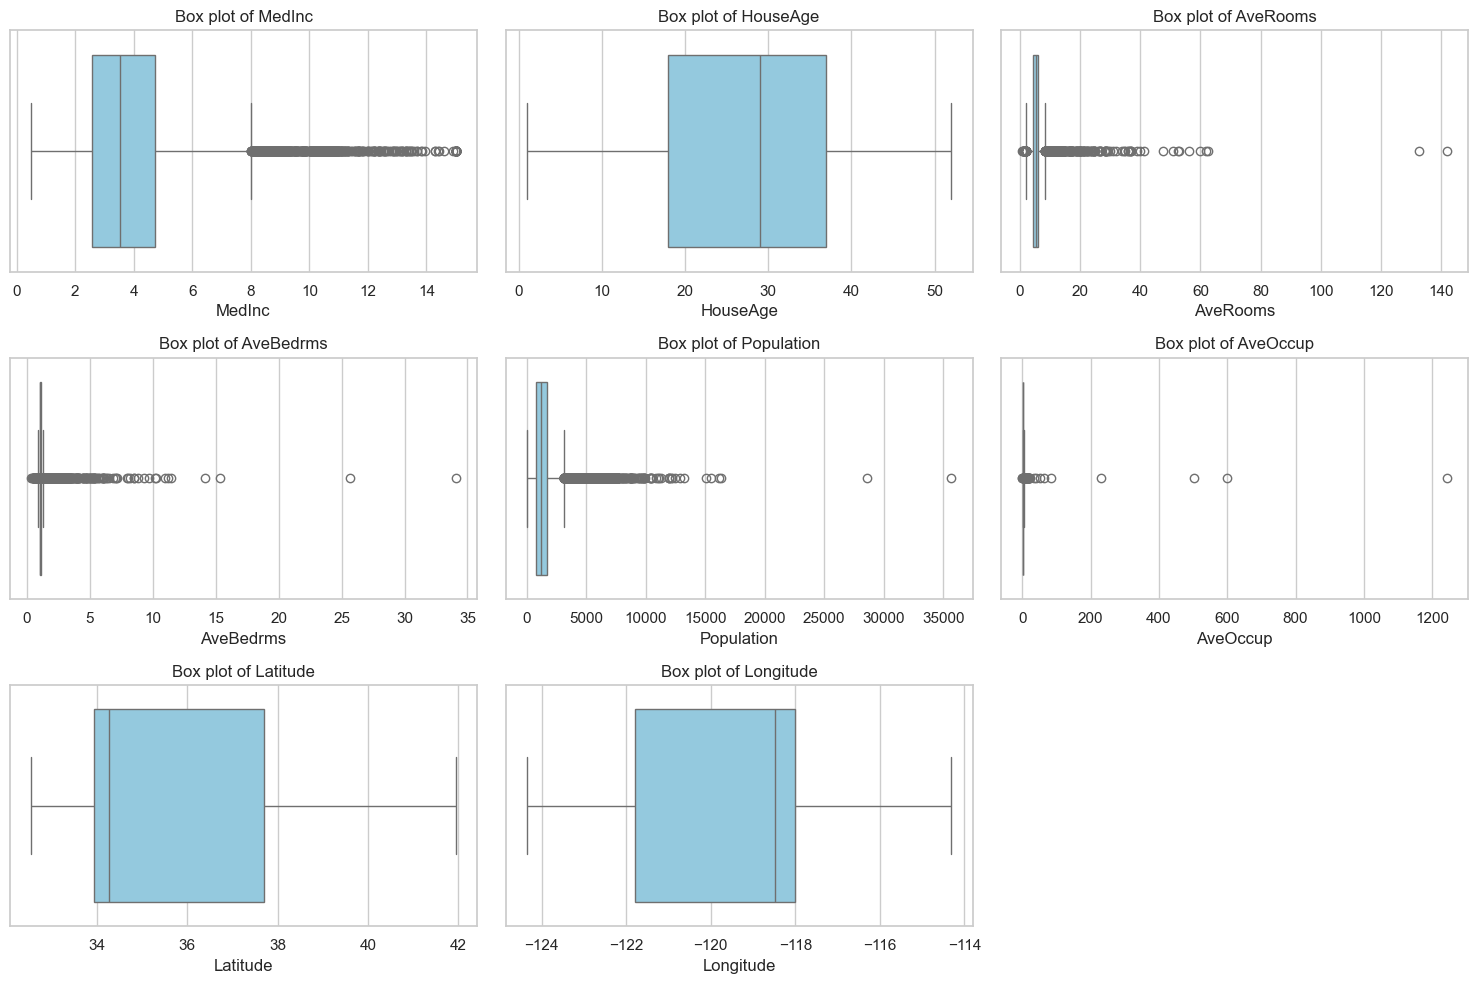

In [25]:
plt.figure(figsize = (15,10))
for i, col in enumerate (df.columns[:-1],1):
    plt.subplot(3,3,i)
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f"Box plot of {col}")
plt.tight_layout()
plt.show()

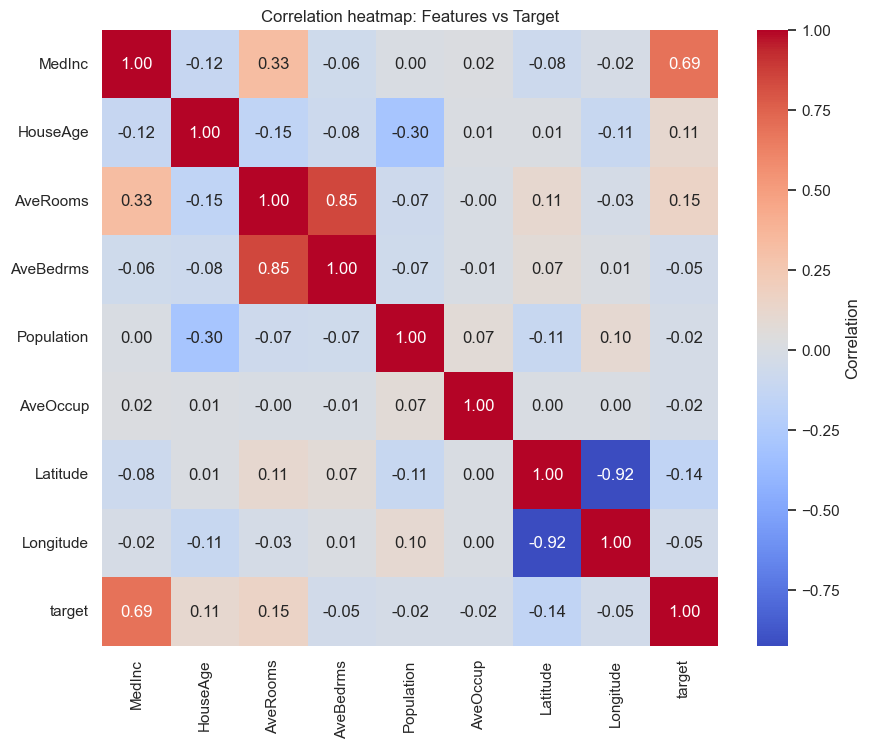

In [3]:
corr = df.corr()
plt.figure(figsize = (10,8))
sns.heatmap(corr, annot=True, fmt= ".2f", cmap= "coolwarm", square=True, cbar_kws={'label':'Correlation'})
plt.title("Correlation heatmap: Features vs Target")
plt.show()

In [26]:
print("Missing values in each column:")
print(df.isnull().sum())

def detect_outliers(df):
    outlier_dict = {}
    for col in df.columns[:-1]:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 *IQR
        upper_bound = Q3 + 1.5 *IQR
        outliers = df[(df[col] < lower_bound) |(df[col]> upper_bound)]
        outlier_dict[col] = outliers.shape[0]
    return outlier_dict
outliers = detect_outliers(df)
print("Outliers per feature:")
for k, v in outliers.items():
    print(f"{k}: {v} outliers")
    

Missing values in each column:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
target        0
dtype: int64
Outliers per feature:
MedInc: 681 outliers
HouseAge: 0 outliers
AveRooms: 511 outliers
AveBedrms: 1424 outliers
Population: 1196 outliers
AveOccup: 711 outliers
Latitude: 0 outliers
Longitude: 0 outliers


In [35]:
df = pd.DataFrame(housing.data, columns=housing.feature_names)
df['target'] = housing.target


df['rooms_per_household'] = df['AveRooms'] / df['HouseAge']


X = df.drop("target", axis=1)
y = df["target"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print(X_train_scaled.columns)


Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'rooms_per_household'],
      dtype='object')


In [36]:
from sklearn.model_selection import train_test_split

a = df.drop("target", axis = 1)
b = df["target"]

a_train, a_test, b_train, b_test, = train_test_split(a,b, test_size = 0.2, random_state = 42)

print(f"Training set size: {a_train.shape}")
print(f"Test set size: {a_test.shape}")

Training set size: (16512, 9)
Test set size: (4128, 9)


In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
a_train_scaled = scaler.fit_transform(a_train)
a_test_scaled = scaler.transform(a_test)

a_train_scaled = pd.DataFrame(a_train_scaled, columns = a.columns)
a_test_scaled = pd.DataFrame(a_test_scaled, columns = a.columns)

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

lr = LinearRegression()
lr.fit(a_train_scaled, b_train)
y_pred_lr = lr.predict(a_test_scaled)

mse_lr = mean_squared_error(b_test, y_pred_lr)
r2_lr = r2_score(b_test, y_pred_lr)

print(f"Linear Regression MSE: {mse_lr:.4f}")
print(f"Linear Regression R2: {r2_lr:.4f}")

Linear Regression MSE: 0.5550
Linear Regression R2: 0.5765


In [39]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and fit
rf = RandomForestRegressor(random_state=42)
rf.fit(a_train_scaled, b_train)

# Predict and evaluate
y_pred_rf = rf.predict(a_test_scaled)
mse_rf = mean_squared_error(b_test, y_pred_rf)
r2_rf = r2_score(b_test, y_pred_rf)

print(f"Random Forest MSE: {mse_rf:.4f}")
print(f"Random Forest R²: {r2_rf:.4f}")


Random Forest MSE: 0.2630
Random Forest R²: 0.7993


In [40]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

# GridSearch with 5-fold CV
grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(a_train_scaled, b_train)

# Best model
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(a_test_scaled)

# Evaluation
mse_best = mean_squared_error(b_test, y_pred_best)
r2_best = r2_score(b_test, y_pred_best)

print("Best Parameters:", grid_search.best_params_)
print(f"Tuned Random Forest MSE: {mse_best:.4f}")
print(f"Tuned Random Forest R²: {r2_best:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Tuned Random Forest MSE: 0.2630
Tuned Random Forest R²: 0.7993


In [41]:
from sklearn.metrics import mean_absolute_error
import numpy as np

def evaluate_model(name, y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"\n{name} Evaluation:")
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²:   {r2:.4f}")
    return r2

# Evaluate best model (from GridSearchCV)
r2_best = evaluate_model("Tuned Random Forest", y_test, y_pred_best)



Tuned Random Forest Evaluation:
MAE:  0.3319
RMSE: 0.5129
R²:   0.7993


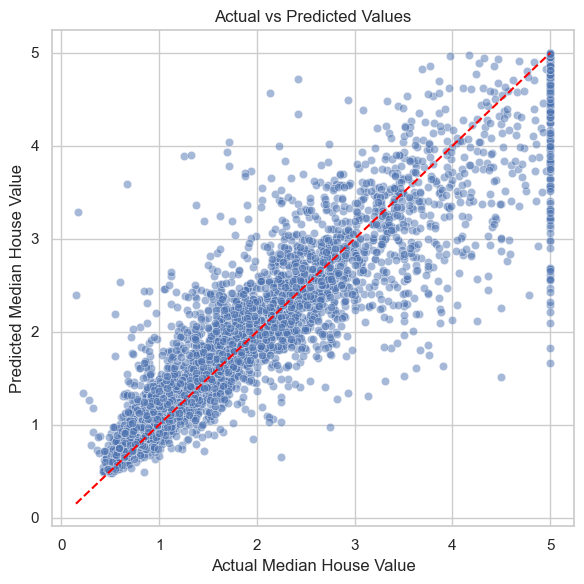

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel("Actual Median House Value")
plt.ylabel("Predicted Median House Value")
plt.title("Actual vs Predicted Values")
plt.grid(True)
plt.tight_layout()
plt.show()


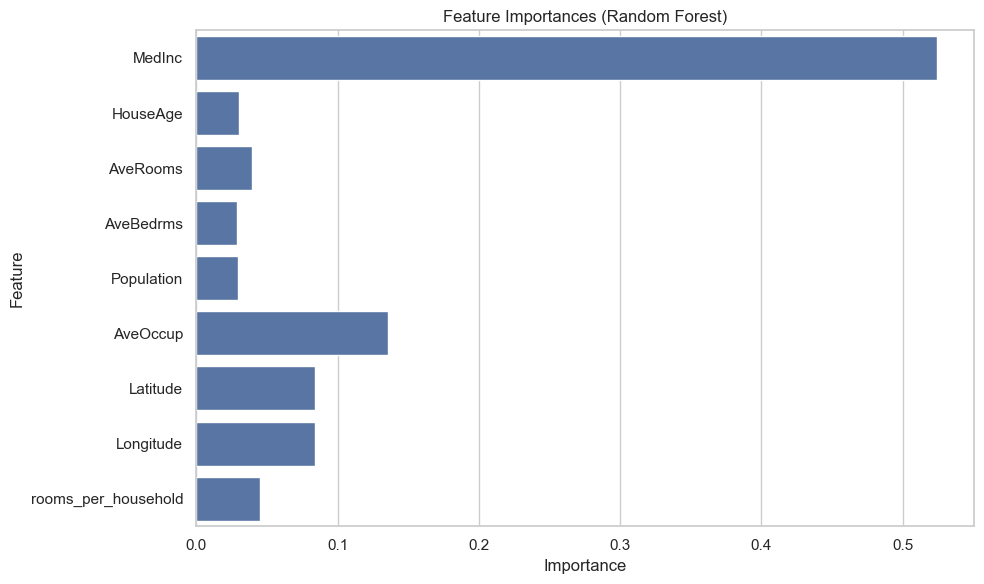

In [43]:
importances = best_rf.feature_importances_
features = X.columns

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=features)
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
